# [ネットワーク分析（基本）](#ネットワーク分析（基本）)

<div>
このNotebookはTircsデータを用いた基本的なネットワーク分析を行うことを目的としている．
</div>
<br>
<div>
    <details>
        <summary>コンテンツ 👇（クリック）</summary>
        <ul>
            <li type="circle"><a href=#準備>準備</a></li>
            <li type="circle"><a href=#データプロファイル>データプロファイル</a></li>
            <li type="circle"><a href=#ネットワーク特徴量>ネットワーク特徴量</a></li>
        </ul>
    </details>
</div>

## [準備](#準備)

<a href=#ネットワーク分析（基本）>トップに戻る</a>

In [1]:
# ライブラリ
import datetime
import itertools
from pathlib import Path
from pprint import pprint

import matplotlib.pyplot as plt
import networkx as nx
import numpy as np
import pandas as pd
import scipy
from pyvis.network import Network

In [2]:
# パス
DATA_DIR = Path("../data")
TRICS_FILE = DATA_DIR / "interim" / "trics_rm.pkl" # 今回は2022年4月だけの1ヶ月間のデータのみ使用

# データ
df_trics = pd.read_pickle(TRICS_FILE)

# 使用するカラム
usecols = [
#     'COUNTRY_FROM',
#     'COUNTRY_TO',
#     'REMITTING_BANK_BIC',
#     'BENEFICIARY_BANK_BIC',
    'REMITTER_ENGLISH', # 企業名（仕向）
    'BENEFICIARY_ENGLISH', # 企業名（非仕向）
    'VALUE_DATE', # 取引処理日
#     'CURRENCY',
#     'AMOUNT',
    'AMOUNT_USD', # 金額（＄）
#     'DETAILS',
#     'DIRECTION',
#     'REMITTER_M_CIF',
#     'REMITTER_PARENT_COMPANY2',
#     'REMITTER_PARENT_M_CIF',
#     'BENEFICIARY_M_CIF',
#     'BENEFICIARY_PARENT_COMPANY2',
#     'BENEFICIARY_PARENT_M_CIF',
#     'ORDERING_COUNTRY_FROM',
#     'ACCOUNT_COUNTRY_TO'
]

# データフレームのカラムを制限する
df_trics = df_trics.loc[:, usecols]

# データチェック
display(df_trics.head())

,REMITTER_ENGLISH,BENEFICIARY_ENGLISH,VALUE_DATE,AMOUNT_USD
0,NISHI NIPPON CITY BANK LTD,REFINITIV TRANSACTION SERVICES LIMI TED FIVE C...,2022-04-25,1424.74
1,FUDEX RUBBER PRODUCTS MALAYSIA SDN BHD,ONO GOMU KOGYO CO LTD,2022-04-25,29115.91
2,QINGDAO ZHONGYIMEIHUI INTERNATIONAL TRADE CO LTD,PANTECH CORP,2022-04-25,15714.00
3,JPB INTERNATIONAL LTD,UTECH CO LTD,2022-04-25,93120.00
4,RENEWABLE SOURCE LTD,RS RENEWABLES KK,2022-04-25,17268.09


企業名があるだけで格段にいいですね（2022/12/12）

<a href=#ネットワーク分析（基本）>トップに戻る</a>

## [データプロファイル](#データプロファイル)

<a href=#ネットワーク分析（基本）>トップに戻る</a>

In [3]:
# データ数
# 月次（総データ数）
print("月次")
display(
    df_trics.agg({"AMOUNT_USD": ["count", "sum", "mean", "max", "median", "min"]})
)

# 週次
print("週次")
display(
    df_trics.assign(WEEK=df_trics.loc[:, "VALUE_DATE"].dt.isocalendar().week)\
    .groupby("WEEK").agg({"AMOUNT_USD": ["count", "sum", "mean", "max", "median", "min"]})
)

# 日次
print("日次")
display(
    df_trics.groupby("VALUE_DATE").agg({"AMOUNT_USD": ["count", "sum", "mean", "max", "median", "min"]})
)

# 曜日ごと
print("曜日ごと")
display(
    df_trics.assign(DAY=df_trics.loc[:, "VALUE_DATE"].dt.isocalendar().day)\
    .groupby("DAY").agg({"AMOUNT_USD": ["count", "sum", "mean", "max", "median", "min"]})
)

月次


,AMOUNT_USD
count,2.722690e+05
sum,2.769070e+11
mean,1.017034e+06
max,6.050000e+09
median,1.807979e+04
min,0.000000e+00


週次


AMOUNT_USD                                                           
          count           sum          mean           max     median   min
WEEK                                                                      
13        11650  1.201918e+10  1.031689e+06  6.131370e+08  18613.715  0.61
14        46174  5.297227e+10  1.147232e+06  1.580250e+09  18173.750  0.02
15        52489  5.135683e+10  9.784304e+05  1.297000e+09  18016.790  0.01
16        59228  6.046570e+10  1.020897e+06  7.917748e+08  19143.085  0.00
17       102728  1.000930e+11  9.743496e+05  6.050000e+09  17537.755  0.01

日次


AMOUNT_USD                                                        \
                count           sum          mean           max      median   
VALUE_DATE                                                                    
2022-04-01      11607  1.200682e+10  1.034447e+06  6.131370e+08   18517.300   
2022-04-02         40  1.235606e+07  3.089015e+05  3.502813e+06   61094.575   
2022-04-03          3  1.216870e+03  4.056233e+02  6.828800e+02     460.940   
2022-04-04       7882  9.734669e+09  1.235051e+06  6.390000e+08   17999.050   
2022-04-05       7666  9.127408e+09  1.190635e+06  4.778901e+08   15461.130   
2022-04-06       7925  7.305126e+09  9.217825e+05  4.242800e+08   19000.000   
2022-04-07       9467  1.130025e+10  1.193646e+06  6.657459e+08   18844.010   
2022-04-08      13229  1.550456e+10  1.172013e+06  1.580250e+09   19033.300   
2022-04-09          4  1.717225e+05  4.293062e+04  8.560410e+04   42929.205   
2022-04-10          1  9.445456e+04  9.445456e+04  9.445456e+04   94454.560   
2022-04-11      11128  1.313422e+10  1.180286e+06  5.005685e+08   19356.165   
2022-04-12       9060  1.103884e+10  1.218415e+06  5.011160e+08   17848.000   
2022-04-13       8939  7.692140e+09  8.605146e+05  4.455090e+08   15964.710   
2022-04-14      11553  1.399292e+10  1.211193e+06  1.297000e+09   18085.020   
2022-04-15      11804  5.498405e+09  4.658086e+05  3.975145e+08   18265.075   
2022-04-16          3  3.057285e+05  1.019095e+05  1.552000e+05  116384.490   
2022-04-17          2  6.550610e+03  3.275305e+03  6.538970e+03    3275.305   
2022-04-18       7920  7.032778e+09  8.879770e+05  2.329150e+08   19528.040   
2022-04-19      10110  1.206318e+10  1.193193e+06  7.917748e+08   19790.560   
2022-04-20      16387  1.303329e+10  7.953433e+05  4.000000e+08   18220.350   
2022-04-21      11318  1.599195e+10  1.412966e+06  6.759467e+08   18170.315   
2022-04-22      13428  1.230538e+10  9.163974e+05  2.516489e+08   19958.155   
2022-04-23          6  2.630489e+05  4.384148e+04  1.691851e+05    6830.915   
2022-04-24         59  3.885293e+07  6.585243e+05  1.157950e+07   48528.520   
2022-04-25      22354  1.628429e+10  7.284734e+05  3.899004e+08   17040.420   
2022-04-26      14450  1.825085e+10  1.263035e+06  6.779304e+08   17282.485   
2022-04-27      17147  2.219477e+10  1.294382e+06  1.250000e+09   19048.550   
2022-04-28      36100  3.284815e+10  9.099211e+05  6.050000e+09   16430.700   
2022-04-29      12674  1.051477e+10  8.296332e+05  5.750000e+08   20000.000   
2022-04-30          3  1.446519e+05  4.821729e+04  6.788197e+04   38784.050   

                      
                 min  
VALUE_DATE            
2022-04-01      0.61  
2022-04-02     94.07  
2022-04-03     73.05  
2022-04-04      0.02  
2022-04-05      0.02  
2022-04-06      0.70  
2022-04-07      0.02  
2022-04-08      0.02  
2022-04-09    259.96  
2022-04-10  94454.56  
2022-04-11      1.00  
2022-04-12      0.01  
2022-04-13      0.12  
2022-04-14      0.09  
2022-04-15      0.39  
2022-04-16  34144.00  
2022-04-17     11.64  
2022-04-18      0.57  
2022-04-19      0.00  
2022-04-20      0.02  
2022-04-21      0.01  
2022-04-22      2.67  
2022-04-23   1158.71  
2022-04-24    466.07  
2022-04-25      0.55  
2022-04-26      0.01  
2022-04-27      0.01  
2022-04-28      0.01  
2022-04-29      0.50  
2022-04-30  37985.86

曜日ごと


AMOUNT_USD                                                            
         count           sum          mean           max     median    min
DAY                                                                       
1        49284  4.618596e+10  9.371391e+05  6.390000e+08  18092.115   0.02
2        41286  5.048027e+10  1.222697e+06  7.917748e+08  17572.945   0.00
3        50398  5.022533e+10  9.965738e+05  1.250000e+09  18215.565   0.01
4        68438  7.413326e+10  1.083218e+06  6.050000e+09  17324.350   0.01
5        62742  5.582994e+10  8.898336e+05  1.580250e+09  19298.265   0.02
6           56  1.324121e+07  2.364502e+05  3.502813e+06  54896.035  94.07
7           65  3.895516e+07  5.993101e+05  1.157950e+07  45784.000  11.64

本分析では，データ量の観点から，日を特定する

<a href=#ネットワーク分析（基本）> Go HEAD! </a>

## [ネットワーク特徴量](#ネットワーク特徴量)

<a href=#ネットワーク分析（基本）>トップに戻る</a>
<br><br>
<div>
    <details>
        <summary>特徴量一覧 &#x1f447;（クリック）</summary>
        <ul>
            <li type="circle"><a href=#次数>次数</a></li>
            <li type="circle"><a href=#クラスター係数>クラスター係数</a></li>
            <li type="circle"><a href=#Assortativity>Assortativity</a></li>
            <li type="circle"><a href=#Assortativity>k-core</a></li>
            <li type="circle"><a href=#Assortativity>k-truss</a></li>
            <li type="circle"><a href=#Assortativity>中心性</a></li>
            <li type="circle"><a href=#Assortativity>連結成分</a></li>
            <li type="circle"><a href=#Assortativity>距離</a></li>
            <li type="circle"><a href=#Assortativity>small-world性</a></li>
            <li type="circle"><a href=#Assortativity>コミュニティ性</a></li>
        </ul>
    </details>
</div>
<br><br>
<div>
    <details>
        <summary>参考サイト &#x1f447;（クリック）</summary>
        <ul>
            <li type="circle"><a href=https://networkx.org/documentation/stable/reference/>NetworkX（公式）</a></li>
            <li type="circle"><a href=https://www.slideshare.net/iwiwi/ss-15517666>大規模ネットワークの性質と先端グラフアルゴリズム</li>
        </ul>
    </details>
</div>

### [次数](#次数)

<a href=#ネットワーク特徴量>&#x1f449; ネットワーク特徴量</a>

<br>
<div>
    参考ページ
    <ul>
        <li href=https://networkx.org/documentation/stable/reference/classes/generated/networkx.Graph.degree.html><a>networkx（公式）</a></li>
    </ul>
</div>

In [4]:
# 日を特定
date_ = datetime.datetime(2022, 4, 28)# 取引回数が最も多い日を選んだが，なんでもいい
# 分析用データフレーム作成
df = df_trics[df_trics["VALUE_DATE"] == date_].copy()

# グラフ作成
# 参考：https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html)
# ノードは企業
# エッジ特徴量は取引額と取引日（取引日をユニークにしているから意味ないけど．．．今後のため）
G = nx.from_pandas_edgelist(
    df,
    source='REMITTER_ENGLISH',
    target='BENEFICIARY_ENGLISH',
    edge_attr=["AMOUNT_USD", "VALUE_DATE"],
    create_using=nx.MultiDiGraph
)
# # 可視化（処理がメチャ重いので実行非推奨）
# nx.draw_circular(G)

In [5]:
# 次数（ノード:次数）
degree = dict(G.degree())
# 入次数（ノード：入次数）
indegree = dict(G.in_degree())
# 出次数（ノード：出次数）
outdegree = dict(G.out_degree())
# 重み付き次数（ノード:重み付き次数）
weighted_degree = dict(G.degree(weight="AMOUNT_USD"))
# 重み付き次数（ノード:重み付き入次数）
weighted_indegree = dict(G.in_degree(weight="AMOUNT_USD"))
# 重み付き次数（ノード:重み付き出次数）
weighted_outdegree = dict(G.out_degree(weight="AMOUNT_USD"))

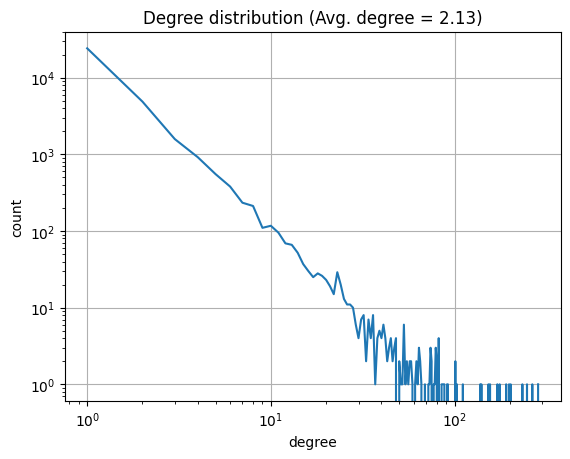

In [6]:
# log-log plot
# スケールフリー性が存在するか確認する
# 次数を格納した配列
arr_ = np.array(list(degree.values()))
# 各次数の出現回数
degree_freq = np.bincount(arr_)[1:]
degree_ = np.arange(1, len(degree_freq) + 1)
# 絵
fig, ax = plt.subplots()
ax.plot(degree_, degree_freq)
# 対数スケールにする
ax.set_xscale('log')
ax.set_yscale('log')
# 軸ラベル
ax.set_xlabel('degree')
ax.set_ylabel("count")
#グリッド
ax.grid("both")
# タイトル
ax.set_title(f'Degree distribution (Avg. degree = {arr_.mean():.2f})')
# 表示
plt.show()

部分的に次数にたいするスケールフリー性がありそう

### [クラスター係数](#クラスター係数)

<a href=#ネットワーク特徴量>&#x1f449; ネットワーク特徴量</a>

<br>
<div>
    参考ページ
    <ul>
        <li href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.cluster.average_clustering.html><a>networkx（公式）</a></li>
        <li><a href=http://jponnela.com/web_documents/a9.pdf>weighted graphに対するクラスタ係数を発表した論文</a></li>
    </ul>
</div>

In [7]:
# 日を特定
date_ = datetime.datetime(2022, 4, 28)# 取引回数が最も多い日を選んだが，なんでもいい
# 分析用データフレーム作成
df = df_trics[df_trics["VALUE_DATE"] == date_].copy()
# クラスター係数は多重グラフでは定義されないため，同じ日における取引はAggする（-> 情報量落ちるけど，日々の特徴を追うのにはこれでもいいか？）
df = df.groupby(["REMITTER_ENGLISH", "BENEFICIARY_ENGLISH"])["AMOUNT_USD"].sum().to_frame().reset_index()

# グラフ作成
# 参考：https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html)
# ノードは企業
# エッジ特徴量は取引額と取引日（取引日をユニークにしているから意味ないけど．．．今後のため）
G = nx.from_pandas_edgelist(
    df,
    source='REMITTER_ENGLISH',
    target='BENEFICIARY_ENGLISH',
    edge_attr=["AMOUNT_USD"],
    create_using=nx.DiGraph
)
# # 可視化（処理がメチャ重いので実行非推奨）
# nx.draw_circular(G)

In [8]:
# 平均クラスター係数
cluster_coefficients = nx.average_clustering(G)
print("cluster coef.: ", cluster_coefficients)
# 重みを考慮した平均クラスター係数
weighted_cluster_coefficients = nx.average_clustering(G, weight="AMOUNT_USD")
print("weghted_cluster coef.: ", weighted_cluster_coefficients)

cluster coef.:  0.004297373255853816
weghted_cluster coef.:  2.5925248571191924e-07


### [Assortativity](#Assortativity)

同類選択性

<a href=#ネットワーク特徴量>&#x1f449; ネットワーク特徴量</a>

<br>
<div>
    参考ページ
    <ul>
        <li href=https://networkx.org/documentation/stable/reference/algorithms/assortativity.html><a>networkx（公式）</a></li>
    </ul>
</div>

In [9]:
# 日を特定
date_ = datetime.datetime(2022, 4, 28)# 取引回数が最も多い日を選んだが，なんでもいい
# 分析用データフレーム作成
df = df_trics[df_trics["VALUE_DATE"] == date_].copy()

# グラフ作成
# 参考：https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html)
# ノードは企業
# エッジ特徴量は取引額と取引日（取引日をユニークにしているから意味ないけど．．．今後のため）
G = nx.from_pandas_edgelist(
    df,
    source='REMITTER_ENGLISH',
    target='BENEFICIARY_ENGLISH',
    edge_attr=["AMOUNT_USD", "VALUE_DATE"],
    create_using=nx.MultiDiGraph
)
# # 可視化（処理がメチャ重いので実行非推奨）
# nx.draw_circular(G)

In [10]:
# degree assortativity
# 次数が高いノード同士がどれほど相関しているか
selections = ["in", "out"]
for x, y in itertools.product(selections, selections):
    assortativity = nx.degree_pearson_correlation_coefficient(G, x=x, y=y)
    print(f'x={x}, y={y}: assortativity = {assortativity}')

x=in, y=in: assortativity = 0.06168542245017626
x=in, y=out: assortativity = 0.044392486211344534
x=out, y=in: assortativity = -0.05673748456929001
x=out, y=out: assortativity = -0.040655075054504185


### [Average degree connectivity](#Average-degree-connectivity)

Connectivity（隣接ノードがどのていど次数をもつか）

<a href=#ネットワーク特徴量>&#x1f449; ネットワーク特徴量</a>

<br>
<div>
    参考ページ
    <ul>
        <li href=https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.assortativity.average_degree_connectivity.html#networkx.algorithms.assortativity.average_degree_connectivity><a>networkx（公式）</a></li>
    </ul>
</div>

In [11]:
# 日を特定
date_ = datetime.datetime(2022, 4, 28)# 取引回数が最も多い日を選んだが，なんでもいい
# 分析用データフレーム作成
df = df_trics[df_trics["VALUE_DATE"] == date_].copy()

# グラフ作成
# 参考：https://networkx.org/documentation/stable/reference/generated/networkx.convert_matrix.from_pandas_edgelist.html)
# ノードは企業
# エッジ特徴量は取引額と取引日（取引日をユニークにしているから意味ないけど．．．今後のため）
G = nx.from_pandas_edgelist(
    df,
    source='REMITTER_ENGLISH',
    target='BENEFICIARY_ENGLISH',
    edge_attr=["AMOUNT_USD", "VALUE_DATE"],
    create_using=nx.MultiDiGraph
)
# # 可視化（処理がメチャ重いので実行非推奨）
# nx.draw_circular(G)

In [12]:
# connectivity
# 隣接ノードの次数がどれほど大きいか
selections = ["in", "out", "in+out"]
for weight in [None, "AMOUNT_USD"]:
    for source, target in itertools.product(selections, selections):
        connectivity = nx.average_neighbor_degree(G, source=source, target=target, weight=weight)
        max_, argmax_ = max(connectivity.values()), max(connectivity, key=connectivity.get)
        min_, argmin_ = min(connectivity.values()), min(connectivity, key=connectivity.get)
        print(f'source={source}, target={target}, weight={weight}')
        print(f'{argmax_}:{max_}\n{argmin_}:{min_}')
        print("-"*30)

source=in, target=in, weight=None
SHANGHAI COMMERCIAL AND SAVINGS BANK LTD:121.0
MALAYSIAN BULK CARRIERS BHD:0.0
------------------------------
source=in, target=out, weight=None
BARKSDALE INC:247.0
MALAYSIAN BULK CARRIERS BHD:0.0
------------------------------
source=in, target=in+out, weight=None
SHANGHAI COMMERCIAL AND SAVINGS BANK LTD:285.0
MALAYSIAN BULK CARRIERS BHD:0.0
------------------------------
source=out, target=in, weight=None
CTRIP COM HONGKONG LTD:121.0
CHONG LEE LEONG SENG CO LTD:0.0
------------------------------
source=out, target=out, weight=None
NOKIA OYJ KARAKAARI 7 FI ESPOO 02610:234.0
MALAYSIAN BULK CARRIERS BHD:0.0
------------------------------
source=out, target=in+out, weight=None
CTRIP COM HONGKONG LTD:285.0
CHONG LEE LEONG SENG CO LTD:0.0
------------------------------
source=in+out, target=in, weight=None
CEREVANCE LTD:121.0
CHONG LEE LEONG SENG CO LTD:0.0
------------------------------
source=in+out, target=out, weight=None
BARKSDALE INC:247.0
MALAYSIAN 